In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
X_full = pd.read_csv('train.csv', index_col='PassengerId')
X_test_full = pd.read_csv('test.csv', index_col='PassengerId')

In [9]:
from sklearn.model_selection import train_test_split

X = X_full[['Name', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived', 'Cabin', 'Ticket']]
X_test = X_test_full[['Name', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'Ticket']]

y = X_full.Survived

X.drop(['Survived'], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

/tmp/ipykernel_12134/2670089295.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(['Survived'], axis=1, inplace=True)


In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# features definidas — agora correspondem à saída do FeatureEngineer
NUMERIC = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Age*Class', 'Age*Fare', 'Fare_log']
CATEGORICAL = ['Sex', 'Embarked', 'Title', 'CabinDeck', 'TicketPrefix']

# preprocessors
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, NUMERIC),
    ('cat', categorical_transformer, CATEGORICAL)
])

In [11]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """Custom transformer que cria Title, CabinDeck e outras features derivadas.
    Recebe um DataFrame com colunas originais (incluindo 'Name','Cabin','Ticket') e retorna
    um DataFrame contendo apenas as colunas listadas em NUMERIC + CATEGORICAL.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Title
        X['Title'] = X['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
        title_mapping = {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'}
        X['Title'] = X['Title'].replace(title_mapping)
        title_mask = ~X['Title'].isin(['Mr', 'Miss', 'Mrs', 'Master'])
        X.loc[title_mask, 'Title'] = X.loc[title_mask, 'Sex'].map({'male': 'Mr', 'female': 'Mrs'})

        # Medians for main titles collected previously manually
        title_age_medians = {
            'Mr': 32.32,
            'Miss': 21.68,
            'Mrs': 35.86,
            'Master': 4.57
        }

            # Fill age based on title medians
        for title, median_age in title_age_medians.items():
            age_mask = (X['Age'].isnull()) & (X['Title'] == title)
            X.loc[age_mask, 'Age'] = median_age
        # Embarked / Fare basic fills (more complexo pode ser feito no pipeline)
        X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode().iloc[0])
        X['Fare'] = X['Fare'].fillna(X['Fare'].median())

        # Derived features
        X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
        X['IsAlone'] = (X['FamilySize'] == 1).astype(int)
        X['Age*Class'] = X['Age'] * X['Pclass']
        X['Age*Fare'] = X['Age'] * X['Fare']
        X['Fare_log'] = np.log1p(X['Fare'])

        # Cabin deck: primeira letra (NaNs virarão np.nan)
        X['CabinDeck'] = X['Cabin'].astype(str).str[0]
        X.loc[X['CabinDeck'].isin(['n', 'N', 'nan']), 'CabinDeck'] = np.nan

        # Ticket prefix (se houver)
        X['TicketPrefix'] = X['Ticket'].astype(str).str.extract(r'([A-Za-z\.\/]+)', expand=False).fillna('NONE')

        keep_cols = NUMERIC + CATEGORICAL
        # Garantir que todas as colunas existem — se alguma faltar, criar com NaN
        for c in keep_cols:
            if c not in X.columns:
                X[c] = np.nan

        return X[keep_cols]


In [12]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np

# Definir pipelines para os modelos que queremos comparar
pipelines = {
    'XGBoost': Pipeline([
        ('feat', FeatureEngineer()),
        ('preproc', preprocessor),
        ('clf', XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=0, use_label_encoder=False, eval_metric='logloss'))
    ]),
    'DecisionTree': Pipeline([
        ('feat', FeatureEngineer()),
        ('preproc', preprocessor),
        ('clf', DecisionTreeClassifier(random_state=0))
    ])
}

# Cross-validation estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scoring = ['accuracy', 'roc_auc']

results = {}
for name, pipe in pipelines.items():
    print(f"Running Stratified 5-fold cross-validation for: {name}...")
    res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    results[name] = res
    print(f"\n{name} results:")
    print(f"  Accuracy: {np.mean(res['test_accuracy']):.4f} ± {np.std(res['test_accuracy']):.4f}")
    print(f"  ROC AUC : {np.mean(res['test_roc_auc']):.4f} ± {np.std(res['test_roc_auc']):.4f}")

# Opcional: você pode treinar o melhor pipeline no dataset completo e gerar previsões
best_pipeline = pipelines['XGBoost']


ModuleNotFoundError: No module named 'xgboost'

In [ ]:
best_pipeline.fit(X, y)
final_predictions = best_pipeline.predict(X_test)

output = pd.DataFrame({'PassengerId': X_test.index,
                       'Survived': final_predictions})
output.to_csv('submission.csv', index=False)

/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [00:16:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Relatório exploratório com Seaborn

Este relatório usa Seaborn e Matplotlib para explorar visualmente o conjunto de treino do Titanic.

Análises incluídas:
- Estatísticas descritivas e resumo rápido dos dados
- Distribuição de sobreviventes por sexo e classe
- Distribuição de idade e fare, com separação por sobrevivência
- Boxplots por Pclass / Survived para Fare e Age
- Heatmap de correlações entre features numéricas
- Taxa de sobrevivência por Pclass x Sex (heatmap)


In [ ]:
# Imports e resumo dos dados
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid')

# se estiver em notebook, ativa display inline (não quebra se não suportado)
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except Exception:
    pass

train = X_full.copy()

print('Primeiras linhas do dataset de treino:')
display(train.head())

print('\nInformações (info):')
train.info()

print('\nResumo numérico:')
display(train.describe())

print('\nResumo geral (inclui categóricas):')
display(train.describe(include='all'))


Primeiras linhas do dataset de treino:


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Informações (info):
<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB

Resumo numérico:


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



Resumo geral (inclui categóricas):


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


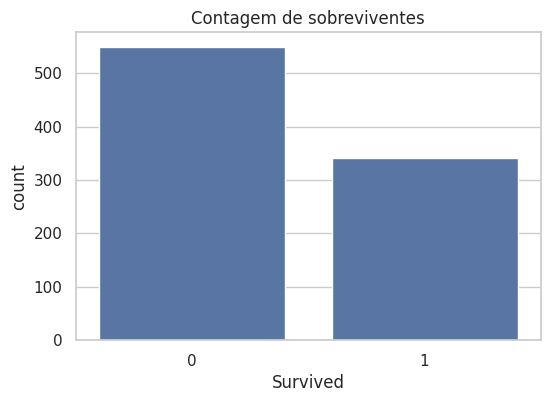

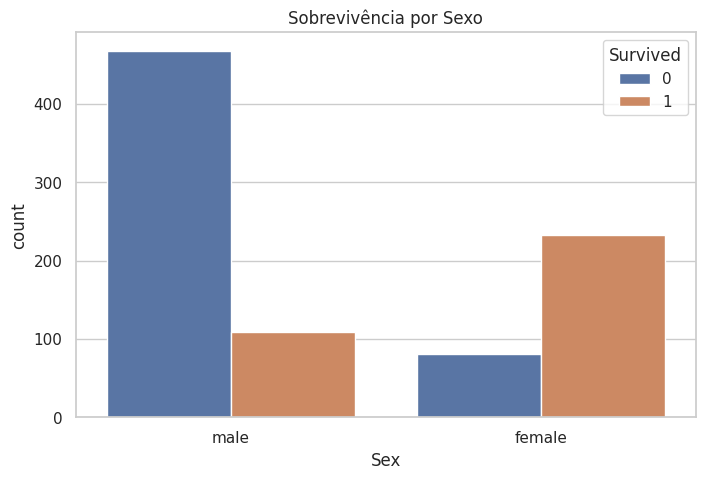

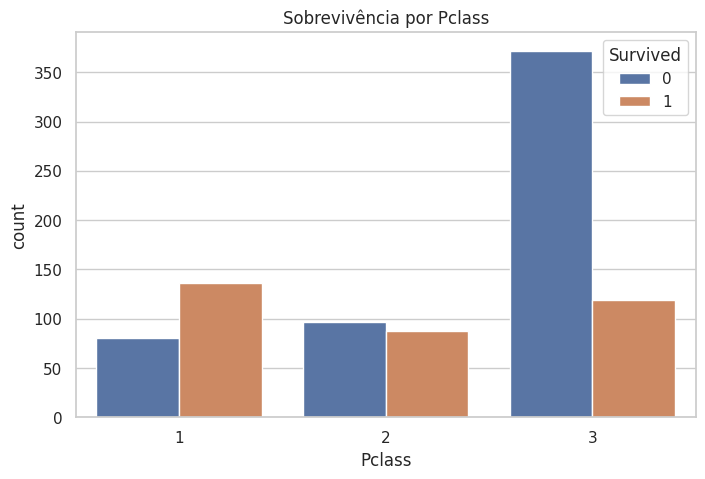

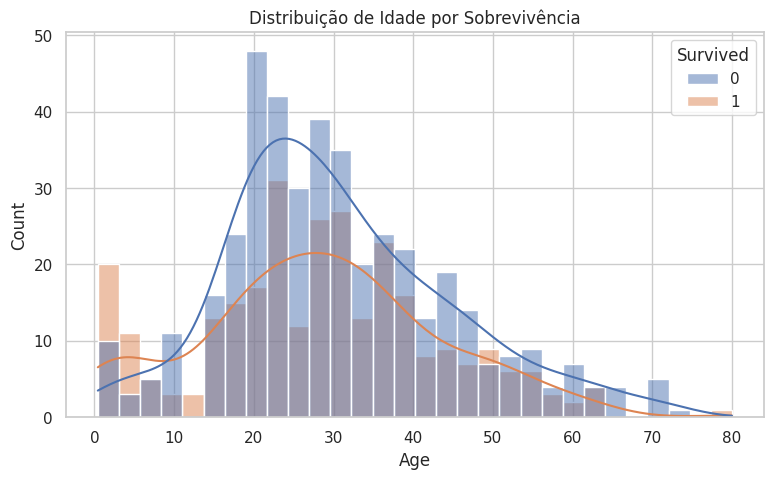

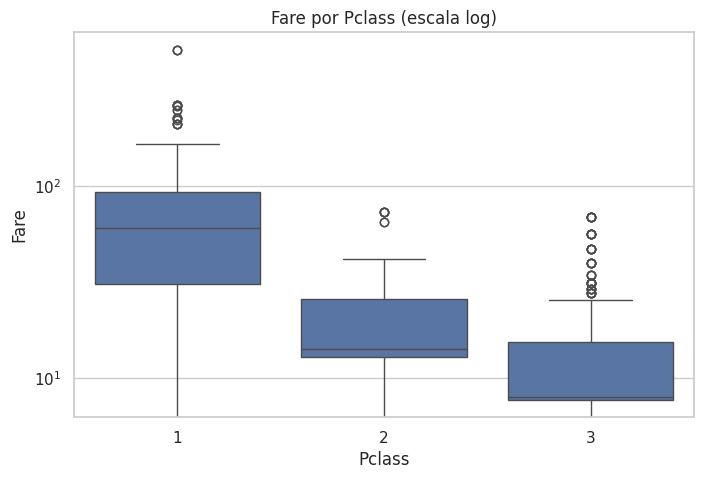

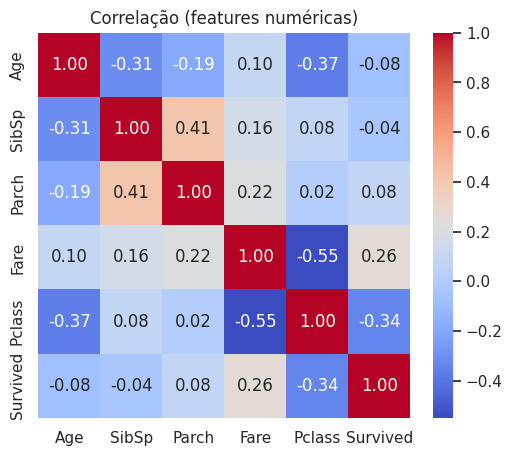

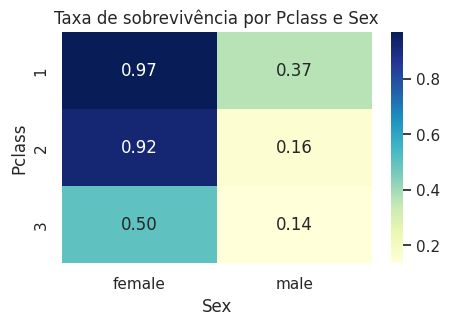

In [ ]:
# Visualizações com Seaborn
import matplotlib.pyplot as plt

# Garantir que usamos o DataFrame original
train = X_full.copy()

# 1) Contagem de sobreviventes
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='Survived')
plt.title('Contagem de sobreviventes')
plt.show()

# 2) Sobrevivência por sexo
plt.figure(figsize=(8,5))
sns.countplot(data=train, x='Sex', hue='Survived')
plt.title('Sobrevivência por Sexo')
plt.show()

# 3) Sobrevivência por classe
plt.figure(figsize=(8,5))
sns.countplot(data=train, x='Pclass', hue='Survived')
plt.title('Sobrevivência por Pclass')
plt.show()

# 4) Distribuição de Idade por sobrevivência
plt.figure(figsize=(9,5))
sns.histplot(data=train, x='Age', hue='Survived', kde=True, bins=30)
plt.title('Distribuição de Idade por Sobrevivência')
plt.show()

# 5) Fare por Pclass (boxplot) - escala log para visualizar melhor extremos
plt.figure(figsize=(8,5))
sns.boxplot(data=train, x='Pclass', y='Fare')
plt.yscale('log')
plt.title('Fare por Pclass (escala log)')
plt.show()

# 6) Heatmap de correlações entre features numéricas
num_cols = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
plt.figure(figsize=(6,5))
corr = train[num_cols + ['Survived']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlação (features numéricas)')
plt.show()

# 7) Taxa de sobrevivência por Pclass x Sex (heatmap)
pivot = train.pivot_table(index='Pclass', columns='Sex', values='Survived', aggfunc='mean')
plt.figure(figsize=(5,3))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Taxa de sobrevivência por Pclass e Sex')
plt.show()
